In [ ]:
import gensim
import re
import spacy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping,ModelCheckpoint

# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [ ]:
#!wget https://archive.org/download/full_grams_cbow_300_twitter/full_grams_cbow_300_twitter.zip
#!unzip full_grams_cbow_300_twitter.zip

# Nouvelle section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# load the AraVec model
model = gensim.models.Word2Vec.load("/content/drive/MyDrive/DataMem/full_grams_sg_300_twitter/full_grams_sg_300_twitter.mdl")
print("We've",len(model.wv.index2word),"vocabularies")

We've 1476715 vocabularies


# Nouvelle section

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
import nltk
#import nltk as nlp
import string
import re


In [ ]:
df= pd.read_excel('/content/drive/MyDrive/DataMem/LabeledDataset.xlsx')

In [ ]:
df.Class.value_counts()

0    11521
1     3529
Name: Class, dtype: int64

In [ ]:
!pip install  alphabet_detector 


  Created wheel for alphabet-detector: filename=alphabet_detector-0.0.7-cp37-none-any.whl size=2446 sha256=9ddcd9839a25a17915d5db7191a54d7cfb953e3d518d4deba1c1c9a6fcae76ee
  Stored in directory: /root/.cache/pip/wheels/75/a7/c3/faf515469622e565475fc96983418ba6e03f6a0f73755cd892
Successfully built alphabet-detector


In [ ]:
# Pretraitement data
 
import re
import string
from alphabet_detector import AlphabetDetector
from bs4 import BeautifulSoup
#definition des diactrics
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

#Suppression des diactrics
def remove_diacritics(text):  #إزالة علامات التشكيل *
    text = re.sub(arabic_diacritics, '', text)
    return text

#Suppression de punctuations
def remove_punctuation(s): 
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»" + "!"
    translator = str.maketrans('', '', my_punctuations)
    return s.translate(translator)


def remove_punctuation2(s): # replace punctuation with space
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»"
    replace_table = str.maketrans(my_punctuations,  ' '*len(my_punctuations))
    return s.translate(replace_table)

#remove text change from html to text
def html2text(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()


#remove other letters
def remove_links(text):
 
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)

# remove empty lines
def remove_empty_lines(text):
    lines = [s.rstrip() for s in text.split("\n") if s.rstrip()]
    return '\n'.join(lines)


def remove_repeating_char(text):
    # return re.sub(r'(.)\1+', r'\1', text)     # keep only 1 repeat
    return re.sub(r'(.)\1+', r'\1\1', text)  # keep 2 repeat

#remove any othe language letters
def keep_only_arabic(text):
    ad = AlphabetDetector()
    clean_lines = list()
    for line in text.splitlines():
        clean_line = list()
        for word in line.split():
            if len(word) > 1:
                if ad.is_arabic(word):
                    if word.isalpha():
                        clean_line.append(word)
        clean_lines.append(' '.join(clean_line))
    return '\n'.join(clean_lines)


def clean_doc(text):
    text = html2text(text)
  
    text = text.replace('\\', ' ')
    text = text.replace('/', ' ')
    text = text.replace('-', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    clean_text = remove_links(text)
    clean_text = remove_diacritics(clean_text)
    clean_text = remove_punctuation2(clean_text)
    clean_text = keep_only_arabic(clean_text)
    clean_text = remove_repeating_char(clean_text)
    clean_text = remove_empty_lines(clean_text)
    return clean_text


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('arabic'))
df['Tweet'] = df['Tweet'].astype(str).values
df['Tweet'] = df['Tweet'].str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stopwords.words('arabic')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل

In [ ]:
#df['body'].values.tolist()

df['Tweet']=df['Tweet'].apply(clean_doc)
df['Tweet']=df['Tweet'].apply(clean_str)

In [ ]:
df.Class.value_counts()

0    11521
1     3529
Name: Class, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X = df['Tweet'].astype(str).values
y= df['Class'].values
   
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
max_num_words=len(X_train)
print(max_num_words)

12040


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
max_num_words =max_num_words
max_length =213

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_val)

X_tr = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
X_tes = pad_sequences(list_tokenized_test, maxlen=max_length, padding='post')


In [ ]:
# Identify max length of reviews
max_length = 0
for review_number in range(len(list_tokenized_train)):
  numberofwords=len(list_tokenized_train [review_number])
  if (numberofwords) > (max_length):
    max_length = numberofwords
print(max_length)

213


In [ ]:
# Show the vocabulory
word_index = tokenizer.word_index
print(tokenizer.word_index)
print('Found %s unique tokens.' % len(word_index))

{'كاظم': 1, 'الله': 2, 'هه': 3, 'احلام': 4, 'الي': 5, 'والله': 6, 'الساهر': 7, 'انتي': 8, 'انا': 9, 'مو': 10, 'القيصر': 11, 'اللي': 12, 'العراق': 13, 'انت': 14, 'واحد': 15, 'راغب': 16, 'شي': 17, 'الكويت': 18, 'لان': 19, 'ان': 20, 'الناس': 21, 'شنو': 22, 'او': 23, 'هاي': 24, 'ليش': 25, 'شو': 26, 'ملكه': 27, 'يعني': 28, 'فنان': 29, 'كان': 30, 'كلهم': 31, 'اي': 32, 'كاضم': 33, 'مش': 34, 'مضغوطين': 35, 'عراقي': 36, 'اني': 37, 'منو': 38, 'تاج': 39, 'ابو': 40, 'فدوه': 41, 'فنانه': 42, 'مثل': 43, 'مصر': 44, 'اصلا': 45, 'احسن': 46, 'انها': 47, 'العرب': 48, 'صوت': 49, 'الفن': 50, 'مين': 51, 'ام': 52, 'اول': 53, 'دي': 54, 'مره': 55, 'الا': 56, 'اذا': 57, 'عليها': 58, 'انو': 59, 'لبنان': 60, 'وين': 61, 'علامه': 62, 'ناس': 63, 'منك': 64, 'وحده': 65, 'علي': 66, 'العربي': 67, 'جدا': 68, 'بالله': 69, 'نفسه': 70, 'انه': 71, 'انسانه': 72, 'انتو': 73, 'احد': 74, 'الخليج': 75, 'رقم': 76, 'العالم': 77, 'محمد': 78, 'كانت': 79, 'الفيديو': 80, 'عشان': 81, 'انسان': 82, 'بنت': 83, 'الغيره': 84, 'اكثر': 85, 'صو

In [ ]:
len(list_tokenized_train)

12040

In [ ]:
X_tr.shape

(12040, 213)

In [ ]:
model["الجزائر"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.22079995, -0.09655558,  0.15987563,  0.34693578, -0.3159536 ,
       -0.20607656, -0.1859537 ,  0.45220947, -0.17164855,  0.1544299 ,
        0.40204754,  0.06728925, -0.01069683, -0.42364204, -0.0909059 ,
       -0.14429599, -0.12658125, -0.35330212,  0.0553798 , -0.4076808 ,
        0.22414882,  0.14760472,  0.12345068,  0.32100272, -0.12636606,
       -0.15519454,  0.20764591, -0.47089946,  0.30368656,  0.05063631,
       -0.4504108 ,  0.22242509,  0.31576812,  0.26084775, -0.6050254 ,
        0.24547292,  0.21151115,  0.20271043,  0.4966088 ,  0.09405285,
        0.3406775 , -0.10617749, -0.02591388,  0.14883104, -0.01668668,
        0.20317729, -0.25998   ,  0.27527493,  0.05829879, -0.08127943,
       -0.1342293 , -0.07736559, -0.04121234,  0.26961243,  0.32734704,
       -0.20927292, -0.18066715, -0.22709996, -0.22569843,  0.22008005,
       -0.5015934 ,  0.11918355,  0.01980907, -0.02562537, -0.3174103 ,
        0.0330741 ,  0.04730427, -0.05302981, -0.01906992,  0.06

In [ ]:
unique_words = len(word_index)
total_words = unique_words+1
skipped_words = 0
embedding_dim = 300  
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, index in tokenizer.word_index.items():
  try:
        embedding_vector = model[word]
  except:
    skipped_words = skipped_words+1
    pass
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
print("Embeddings Matrix shape : ",embedding_matrix.shape)

Embeddings Matrix shape :  (27360, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
#embedding_matrix[27498]-model.wv['تمس']

In [ ]:
from tensorflow.keras.layers import *
# create the embedding layer
embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length)

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM,Conv1D,GlobalMaxPooling1D, MaxPooling1D,Dense,Bidirectional,Flatten## Neural networks layers 
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.optimizers import SGD,RMSprop,Adam

opt = RMSprop(lr=0.001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# **Hybridation CNN_Bilstm** 

In [ ]:
        model3= Sequential()
        model3.add(embedding_layer ) 
        model3.add(Conv1D(250, 7,activation='relu',padding="valid", strides=1))
        
        model3.add(MaxPooling1D(pool_size=3))
        model3.add(Bidirectional(LSTM(units=250,return_sequences=True)))
        model3.add(Flatten())
        model3.add(Dense(250, activation='relu'))
        model3.add(Dropout(0.3))
        model3.add(Dense(1))
        model3.add(Activation('sigmoid'))
        

print(model3.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 213, 300)          8208000   
_________________________________________________________________
conv1d (Conv1D)              (None, 207, 250)          525250    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 250)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 69, 500)           1002000   
_________________________________________________________________
flatten (Flatten)            (None, 34500)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               8625250   
_________________________________________________________________
dropout (Dropout)            (None, 250)               0

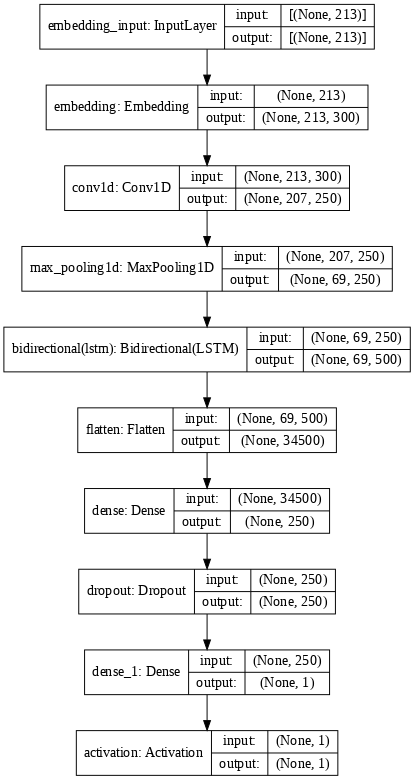

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model3, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:

nb_epochs=10

model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
csv_logger = CSVLogger('/content/training01.log', separator=',', append=False)
callbacks = [
 EarlyStopping(monitor='val_accuracy', mode='max',
                              patience=nb_epochs, verbose=1),
ModelCheckpoint(filepath = '/content/model_best.h5', monitor='val_accuracy', mode='max',
                            verbose=1, save_best_only=True, save_weights_only = True),
        csv_logger
    ]
history=model3.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=nb_epochs,batch_size=32,verbose=1,callbacks=callbacks)


Epoch 1/10
377/377 [==============================] - 55s 52ms/step - loss: 0.4384 - accuracy: 0.8276 - val_loss: 0.3893 - val_accuracy: 0.8545

Epoch 00001: val_accuracy improved from -inf to 0.85449, saving model to /content/model_best.h5
Epoch 2/10
377/377 [==============================] - 19s 50ms/step - loss: 0.3213 - accuracy: 0.8783 - val_loss: 0.4865 - val_accuracy: 0.8635

Epoch 00002: val_accuracy improved from 0.85449 to 0.86346, saving model to /content/model_best.h5
Epoch 3/10
377/377 [==============================] - 19s 50ms/step - loss: 0.2298 - accuracy: 0.9137 - val_loss: 0.4693 - val_accuracy: 0.8568

Epoch 00003: val_accuracy did not improve from 0.86346
Epoch 4/10
377/377 [==============================] - 19s 49ms/step - loss: 0.1780 - accuracy: 0.9356 - val_loss: 0.8830 - val_accuracy: 0.8585

Epoch 00004: val_accuracy did not improve from 0.86346
Epoch 5/10
377/377 [==============================] - 19s 49ms/step - loss: 0.1643 - accuracy: 0.9407 - val_loss: 0

# Graphe train test accuracy



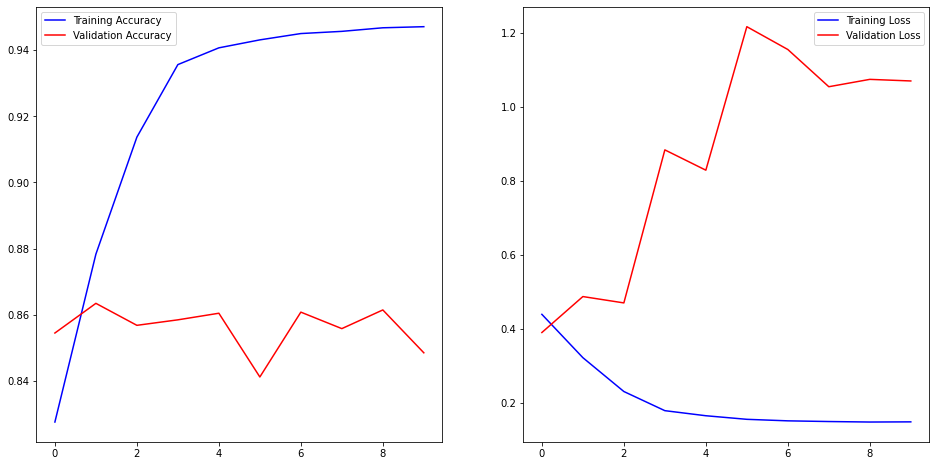

In [ ]:
history = pd.read_csv('/content/training01.log', sep=',', engine='python')
hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()



plt.show()

In [ ]:
y_test= model3.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8485 

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2338
           1       0.69      0.57      0.63       672

    accuracy                           0.85      3010
   macro avg       0.79      0.75      0.77      3010
weighted avg       0.84      0.85      0.84      3010



In [ ]:
#model3.save('/content/drive/MyDrive/DataMem/model_CNN_BiLSTM_emb40_Al_Jazeera_250_7.h5')

In [ ]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#print(model3.summary())
history=model3.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=10,batch_size=64,verbose=1)

Epoch 1/10
189/189 [==============================] - 27s 128ms/step - loss: 0.1406 - accuracy: 0.9473 - val_loss: 0.9991 - val_accuracy: 0.8581
Epoch 2/10
189/189 [==============================] - 23s 121ms/step - loss: 0.1394 - accuracy: 0.9481 - val_loss: 0.7978 - val_accuracy: 0.8568
Epoch 3/10
189/189 [==============================] - 23s 121ms/step - loss: 0.1418 - accuracy: 0.9472 - val_loss: 0.7417 - val_accuracy: 0.8661
Epoch 4/10
189/189 [==============================] - 23s 121ms/step - loss: 0.1371 - accuracy: 0.9481 - val_loss: 0.7493 - val_accuracy: 0.8518
Epoch 5/10
189/189 [==============================] - 23s 122ms/step - loss: 0.1323 - accuracy: 0.9488 - val_loss: 0.8983 - val_accuracy: 0.8625
Epoch 6/10
189/189 [==============================] - 23s 121ms/step - loss: 0.1302 - accuracy: 0.9499 - val_loss: 1.0282 - val_accuracy: 0.8611
Epoch 7/10
189/189 [==============================] - 23s 121ms/step - loss: 0.1298 - accuracy: 0.9498 - val_loss: 1.0144 - val_ac

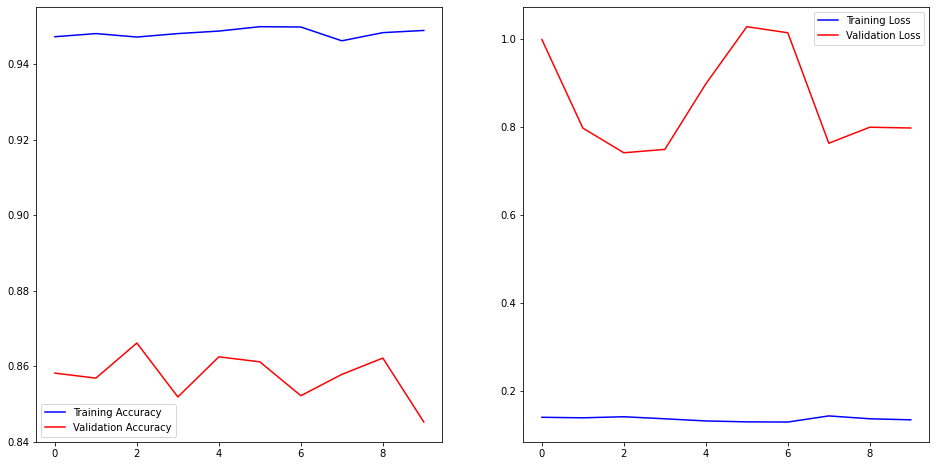

In [ ]:

hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

In [ ]:
y_test= model3.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8452 

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2338
           1       0.67      0.59      0.63       672

    accuracy                           0.85      3010
   macro avg       0.78      0.76      0.77      3010
weighted avg       0.84      0.85      0.84      3010



# **BiLSTM**

In [ ]:
model2=Sequential()
model2.add(embedding_layer ) 

model2.add(Bidirectional( LSTM(units=250,return_sequences=True)))

model2.add(Flatten())

model2.add(Dense(400, activation='relu'))
model2.add(Dropout(0.2))
#Output  Layer

model2.add(Dense(1, activation='sigmoid')) 

#model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

print(model2.summary())
#model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=15,batch_size=32,verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 213, 300)          8208000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 213, 500)          1102000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 106500)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               42600400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 51,910,801
Trainable params: 51,910,801
Non-trainable params: 0
__________________________________________

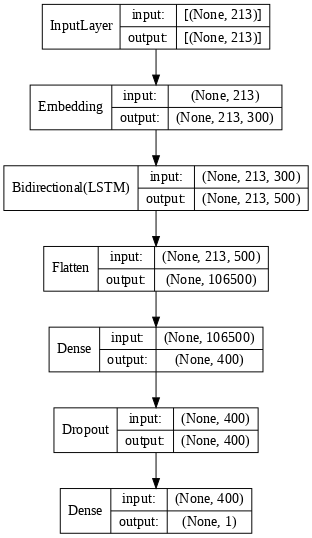

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model2, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = False, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:

model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
csv_logger = CSVLogger('/content/training03.log', separator=',', append=False)
callbacks = [
 EarlyStopping(monitor='val_accuracy', mode='max',
                              patience=2, verbose=1),
#ModelCheckpoint(filepath = '/content/model_best_thebestt.h5', monitor='val_accuracy', mode='max',
                       #     verbose=1, save_best_only=True, save_weights_only = True),
        csv_logger
    ]


In [ ]:
K.clear_session()
opt=Adam(learning_rate=0.0001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=10,batch_size=32,callbacks=callbacks)


Epoch 1/10
377/377 [==============================] - 52s 131ms/step - loss: 0.2719 - accuracy: 0.9037 - val_loss: 0.3831 - val_accuracy: 0.8578
Epoch 2/10
377/377 [==============================] - 48s 127ms/step - loss: 0.2361 - accuracy: 0.9138 - val_loss: 0.4324 - val_accuracy: 0.8638
Epoch 3/10
377/377 [==============================] - 48s 127ms/step - loss: 0.2118 - accuracy: 0.9228 - val_loss: 0.4696 - val_accuracy: 0.8551
Epoch 4/10
377/377 [==============================] - 48s 127ms/step - loss: 0.1882 - accuracy: 0.9308 - val_loss: 0.4953 - val_accuracy: 0.8502
Epoch 00004: early stopping


In [ ]:
y_test= model2.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))


			PERFORMANCE

Accuracy: 0.8502 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2338
           1       0.72      0.54      0.62       672

    accuracy                           0.85      3010
   macro avg       0.80      0.74      0.76      3010
weighted avg       0.84      0.85      0.84      3010



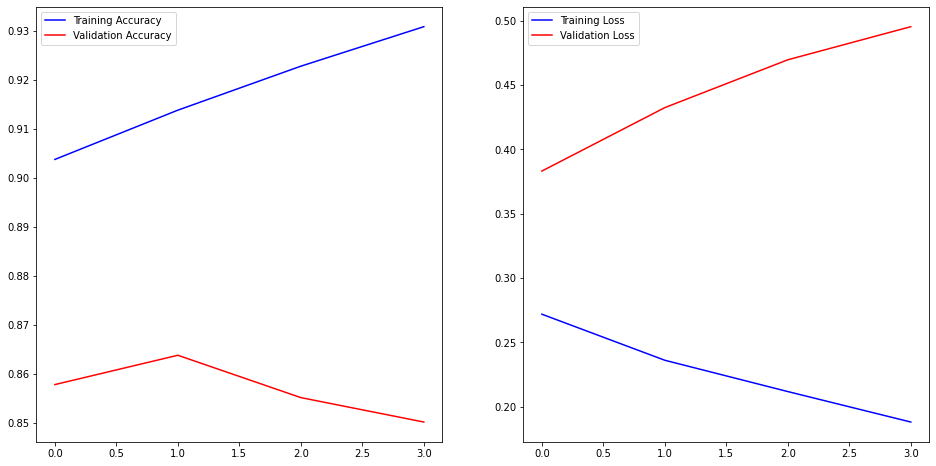

In [ ]:
#history = pd.read_csv('/content/training03.log', sep=',', engine='python')
hist=history.history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()



plt.show()

In [ ]:
#model2.save('/content/drive/MyDrive/DataMem/BiLSTM_emb40_Al_Jazeera.h5')

In [ ]:

opt=SGD(learning_rate=0.001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=5,batch_size=128,callbacks=callbacks)


Epoch 1/5
95/95 [==============================] - 14s 124ms/step - loss: 0.1676 - accuracy: 0.9391 - val_loss: 0.5088 - val_accuracy: 0.8535
Epoch 2/5
95/95 [==============================] - 11s 118ms/step - loss: 0.1669 - accuracy: 0.9394 - val_loss: 0.5164 - val_accuracy: 0.8548
Epoch 3/5
95/95 [==============================] - 11s 117ms/step - loss: 0.1667 - accuracy: 0.9393 - val_loss: 0.5172 - val_accuracy: 0.8545
Epoch 4/5
95/95 [==============================] - 11s 116ms/step - loss: 0.1669 - accuracy: 0.9388 - val_loss: 0.5202 - val_accuracy: 0.8542
Epoch 00004: early stopping


In [ ]:
scores = model2.evaluate(X_tes, y_val, verbose=1)
print("\n%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))


95/95 [==============================] - 2s 16ms/step - loss: 0.5202 - accuracy: 0.8542

accuracy: 85.42%


In [ ]:
y_test= model2.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8542 

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2338
           1       0.74      0.53      0.62       672

    accuracy                           0.85      3010
   macro avg       0.81      0.74      0.77      3010
weighted avg       0.85      0.85      0.85      3010



# Hybridation

Modif param

In [ ]:
        model4= Sequential()
        model4.add(embedding_layer ) 
        model4.add(Conv1D(250, 3,activation='relu',padding="valid", strides=1))
        
        model4.add(MaxPooling1D(pool_size=3))
        model4.add(Bidirectional(LSTM(units=250,return_sequences=True)))
        model4.add(Flatten())
        model4.add(Dense(250, activation='relu'))
        model4.add(Dropout(0.3))
        model4.add(Dense(1))
        model4.add(Activation('sigmoid'))
        
#model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model4.summary())
#model4.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=15,batch_size=32,verbose=1)
        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 213, 300)          8208000   
_________________________________________________________________
conv1d (Conv1D)              (None, 211, 250)          225250    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 250)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 500)           1002000   
_________________________________________________________________
flatten (Flatten)            (None, 35000)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               8750250   
_________________________________________________________________
dropout (Dropout)            (None, 250)               0

In [ ]:
#model3.save('/content/drive/MyDrive/DataMem/model_CNN_BiLSTM_emb40_Al_Jazeera_250_3.h5')

In [ ]:
opt=Adam(learning_rate=0.01)
model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history=model4.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=15,batch_size=32,verbose=1,callbacks=callbacks)

Epoch 1/15
377/377 [==============================] - 45s 111ms/step - loss: 0.8837 - accuracy: 0.7564 - val_loss: 0.4772 - val_accuracy: 0.7767
Epoch 2/15
377/377 [==============================] - 41s 109ms/step - loss: 0.5627 - accuracy: 0.7592 - val_loss: 0.5311 - val_accuracy: 0.7767
Epoch 3/15
377/377 [==============================] - 41s 108ms/step - loss: 0.5479 - accuracy: 0.7627 - val_loss: 0.5336 - val_accuracy: 0.7767
Epoch 00003: early stopping


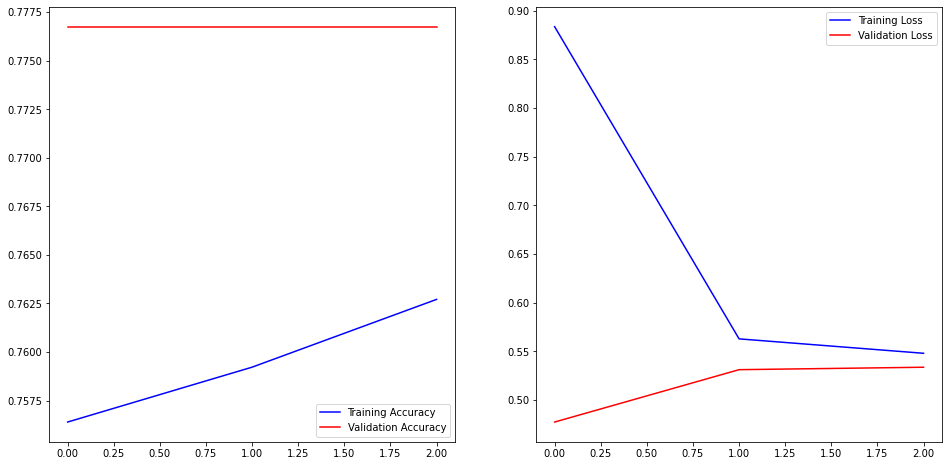

In [ ]:



hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()



plt.show()

In [ ]:
y_test= model4.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.7767 

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      2338
           1       0.00      0.00      0.00       672

    accuracy                           0.78      3010
   macro avg       0.39      0.50      0.44      3010
weighted avg       0.60      0.78      0.68      3010



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

phrase1 = ['ابن كلب كان يردح على الحريات وقت الإخوان بس لما العسكر يقمعوا الحريات عادي']
phrase2=['دخل هالبسمة يا قاهرهم ',]

seq1= tokenizer.texts_to_sequences(phrase1)
seq2= tokenizer.texts_to_sequences(phrase2)
data1 = pad_sequences(seq1, maxlen= 213 , padding='post')
data2 = pad_sequences(seq2, maxlen= 213 , padding='post')

prediction1=model3.predict(data1)
prediction2=model3.predict(data2)
print('predection \n  1 : ',prediction1 , '\n 2: ',prediction2)
###################################
##classes= df['languagecomment'].unique()
##print(classes)
##print(np.argmax(prediction))
##pred_name = classes[np.argmax(prediction)]
##print(pred_name)

predection 
  1 :  [[1.]] 
 2:  [[1.5459234e-06]]
